In [16]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import hashlib

#### **Check for duplicate images**

In [19]:
def calculate_hash(file_path):
    with open(file_path, 'rb') as f:
        image_hash = hashlib.md5(f.read()).hexdigest()
    return image_hash

In [21]:
main_folder = "dataset"
classes = os.listdir("dataset")

hash_dict = {}
duplicates = []

# Calculate hash values for each image
# Add images that are have same hash value to duplicates list

# Iterate over classes
for class_folder in classes:
    class_path = os.path.join(main_folder, class_folder)

    # Iterate over images
    for filename in os.listdir(class_path):
        image_path = os.path.join(class_path, filename)
        image_hash = calculate_hash(image_path)

        # If the same image exists, add it to the list
        if image_hash in hash_dict:
            duplicates.append((image_path, hash_dict[image_hash]))
            
        # If not add it to hash table
        else:
            hash_dict[image_hash] = image_path

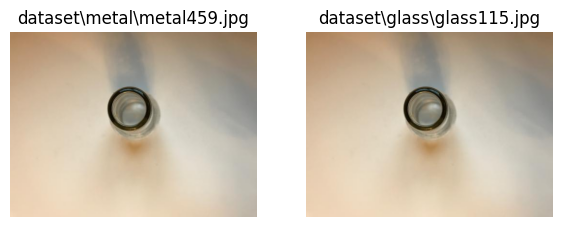

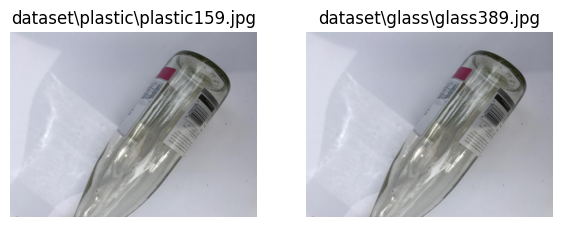

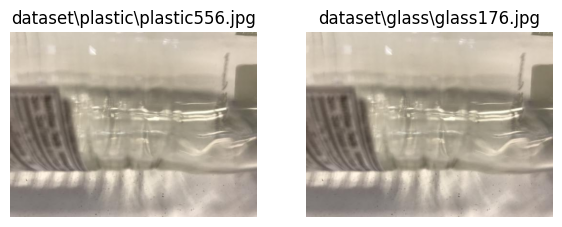

In [22]:
# Show duplicate images
for image1, image2 in duplicates:
    fig, ax = plt.subplots(1, 2, figsize=(7,7))

    # Show Image 1
    ax[0].imshow(Image.open(image1))
    ax[0].axis('off')
    ax[0].set_title(image1)

    # Show Image 2
    ax[1].imshow(Image.open(image2))
    ax[1].axis('off')
    ax[1].set_title(image2)
    
    plt.show()

According to results, removed and correct files are below:

| Correct label | Removed file |
|:--------:|:--------:|
| glass115.jpg   | metal459.jpg   |
| glass389.jpg   | plastic159.jpg |
| plastic556.jpg | glass176.jpg   |

* The misclassified duplicate files are removed by hand.

### **Split train and test sets**

In [21]:
X = []
y = []

# Read images and labels
# Iterate over classes
for class_folder in classes:
    class_path = os.path.join(main_folder, class_folder)

    # Iterate over images
    for filename in os.listdir(class_path):
        # Read the image
        image_path = os.path.join(class_path, filename)
        image = Image.open(image_path)

        # Resize it to 128x128
        if(image.size != (128,128)):
            image = image.resize(size=(128,128))

        # Convert to RGB
        image = image.convert("RGB")

        # Convert to numpy array
        image = np.array(image)

        # Flatten the image
        image = image.flatten()

        X.append(image)
        y.append(class_folder)

X = np.array(X)
y = np.array(y)

# Encode y array
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split train and test sets
from sklearn.model_selection import train_test_split

# The resulting splits are stratified, which means class balance is preserved
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

* `train_test_split` function shuffles the dataset before splitting.

* The distribution of classes are preserved in resulting train and test sets, with `stratify=y` parameter.

### **Class Distributions in the Dataset**

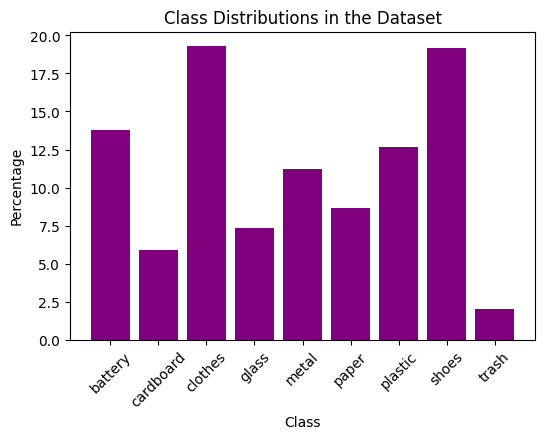

In [22]:
# Unique classes in the dataset
classes = np.unique(y)

# Count occurrences of each class in the dataset
dataset_counts = np.bincount(y, minlength=len(classes))

# Convert counts to percentages
dataset_percentages = (dataset_counts / len(y)) * 100

# Plot class distributions for the dataset
fig, ax = plt.subplots(1, 1, figsize=(6,4))
decoded_labels = label_encoder.inverse_transform(classes)

ax.bar(classes, dataset_percentages, color='purple')
ax.set_title('Class Distributions in the Dataset')
ax.set_xlabel('Class')
ax.set_ylabel('Percentage')
ax.set_xticks(range(len(classes)), decoded_labels, rotation=45)

plt.show()

* The classes are imbalanced even after the data augmentation.

### **Class Distributions in the Train and Test Sets**

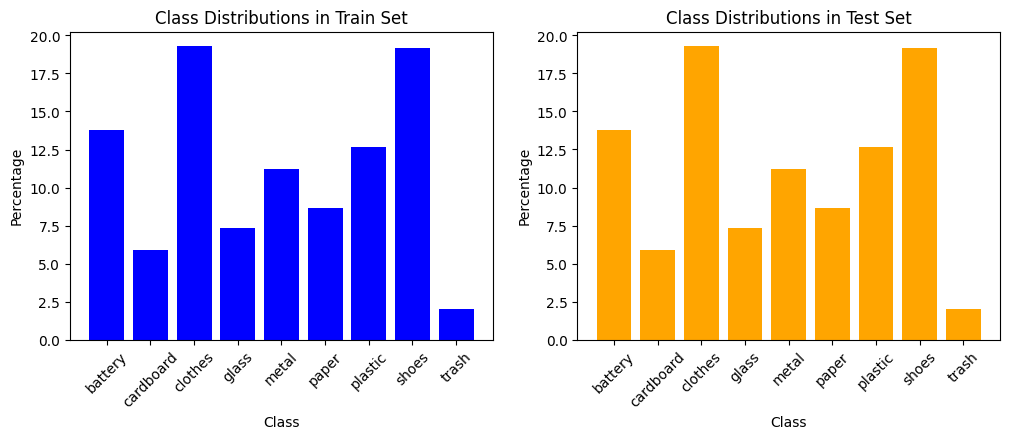

In [23]:
# Count occurrences of each class in y_train and y_test
train_counts = np.bincount(y_train, minlength=len(classes))
test_counts = np.bincount(y_test, minlength=len(classes))

# Convert counts to percentages
train_percentages = (train_counts / len(y_train)) * 100
test_percentages = (test_counts / len(y_test)) * 100

# Plot class distributions
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Plot class distribution for training set
ax[0].bar(classes, train_percentages, color='blue')
ax[0].set_title('Class Distributions in Train Set')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Percentage')
ax[0].set_xticks(range(len(classes)), decoded_labels, rotation=45)

# Plot class distribution for testing set
ax[1].bar(classes, test_percentages, color='orange')
ax[1].set_title('Class Distributions in Test Set')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Percentage')
ax[1].set_xticks(range(len(classes)), decoded_labels, rotation=45)

plt.show()

* The distribution of classes are same with the orginal dataset

### **Save Splits as .npy for Later Use**

In [ ]:
if not os.path.exists("dataset_npy"):
    os.makedirs("dataset_npy")

np.save(r'dataset_npy\X_train.npy', X_train)
np.save(r'dataset_npy\y_train.npy', y_train)
np.save(r'dataset_npy\X_test.npy', X_test)
np.save(r'dataset_npy\y_test.npy', y_test)